In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time

In [9]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [10]:
from utils import check_fashion_mnist_dataset_exists
data_path=check_fashion_mnist_dataset_exists()

train_data=torch.load(data_path+'fashion-mnist/train_data.pt')
train_label=torch.load(data_path+'fashion-mnist/train_label.pt')
test_data=torch.load(data_path+'fashion-mnist/test_data.pt')
test_label=torch.load(data_path+'fashion-mnist/test_label.pt')

print(train_data.size())
print(test_data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [11]:
class Stem(nn.Module):

    def __init__(self):

        super(Stem, self).__init__()
        
        #----------------------- stem block start ----------------------------
        
        #self.padding = nn.ZeroPad2d((133,134,133,134))
        #self.padding = nn.ReplicationPad2d((133,134,133,134))
        
        self.resize = nn.UpsamplingBilinear2d(size=(299,299))
        
        #1 x 299 x 299 --> 32 x 149 x 149  , VALID Padding 
        self.conv1a = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=0 ) 
        
        self.bn1a = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)
        
        #32 x 149 x 149 --> 32 x 147 x 147  , VALID Padding 
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0 )
        
        self.bn1b = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)
        
        #32 x 147 x 147 --> 64 x 147 x 147  , SAME Padding 
        self.conv1c = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1 )
        
        self.bn1c = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #======================== Filter concat 1 =============================
        
        #64 x 147 x 147 --> 64 x 73 x 73, kernel size = 3, VALID Padding  
        self.pool1  = nn.MaxPool2d(kernel_size=3, stride=2, padding=0 )
        
        #64 x 147 x 147 --> 96 x 73 x 73  , VALID Padding
        self.conv2a = nn.Conv2d(64, 96, kernel_size=3, stride=2, padding=0 )
        
        self.bn2a = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #======================== Filter concat 1 =============================
        
        #======================== Filter concat 2 =============================       
        
        #160 x 73 x 73 --> 64 x 73 x 73  , SAME Padding   Find out the size of output
        self.conv3a = nn.Conv2d(160, 64, kernel_size=1, padding=0 )
        
        self.bn3a = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #64 x 73 x 73 --> 96 x 71 x 71  , VALID Padding   Find out the size of output
        self.conv3b = nn.Conv2d(64, 96, kernel_size=3, padding=0 )
        
        self.bn3b = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #160 x 73 x 73 --> 64 x 73 x 73  , SAME Padding   Might be combined with self.conv1e1
        self.conv4a = nn.Conv2d(160, 64, kernel_size=1, padding=0 )
        
        self.bn4a = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #64 x 73 x 73 --> 64 x 73 x 73  , SAME Padding   Find out the size of output
        self.conv4b = nn.Conv2d(64, 64, kernel_size=[7,1], padding=[3,0] )
        
        self.bn4b = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #64 x 73 x 73 --> 64 x 73 x 73  , SAME Padding   Find out the size of output
        self.conv4c = nn.Conv2d(64, 64, kernel_size=[1,7], padding=[0,3]  )
        
        self.bn4c = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #64 x 73 x 73 --> 96 x 71 x 71  , VALID Padding   Might be combined with self.conv1e2
        self.conv4d = nn.Conv2d(64, 96, kernel_size=3, padding=0 )
        
        self.bn4d = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #======================== Filter concat 2 ============================= 
        
        #======================== Filter concat 3 =============================
        
        #192 x 71 x 71 --> 192 x 35 x 35  , VALID Padding 
        self.conv5a = nn.Conv2d(192, 192, kernel_size=3, stride=2, padding=0 )
        
        self.bn5a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
         
        #192 x 71 x 71 --> 192 x 35 x 35, kernel size = 3, VALID Padding
        self.pool2  = nn.MaxPool2d(kernel_size=3, stride=2, padding=0 )
        
        #======================== Filter concat 3 =============================
        
        #----------------------- stem block finish ----------------------------
        
    def forward(self, x):

        # block 1: 
        #x = self.padding(x)
        x= self.resize(x)
        
        x = self.conv1a(x)
        x = self.bn1a(x)
        x = F.relu(x)
        
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = F.relu(x)
        
        
        x = self.conv1c(x)
        x = self.bn1c(x)
        x = F.relu(x)
        
        
        xP = self.pool1(x)
        xC = self.conv2a(x)
        xC = self.bn2a(xC)
        xC = F.relu(xC)
        xFC1 = torch.cat((xP, xC), 1)
        
        y = self.conv3a(xFC1)
        y = self.bn3a(y)
        y = F.relu(y)
        
        y = self.conv3b(y)
        y = self.bn3b(y)
        y = F.relu(y)

        z = self.conv4a(xFC1)
        z = self.bn4a(z)
        z = F.relu(z)
        z = self.conv4b(z)
        z = self.bn4b(z)
        z = F.relu(z)
        z = self.conv4c(z)
        z = self.bn4c(z)
        z = F.relu(z)
        z = self.conv4d(z)
        z = self.bn4d(z)
        z = F.relu(z)
        
        # Above code or this one?
        #z = self.conv3a(xFC1)
        #z = F.relu(z)
        #z = self.conv4b(z)
        #z = F.relu(z)
        #z = self.conv4c(xFC1)
        #z = F.relu(z)
        #z = self.conv3b(z)
        #z = F.relu(z)
        
        xFC2 = torch.cat((y, z), 1)
        
        xP = self.pool2(xFC2)
        xC = self.conv5a(xFC2)
        xC = self.bn5a(xC)
        xC = F.relu(xC)
        xFC3 = torch.cat((xP, xC), 1)   
        #print('Stem Done')
        
        return xFC3

In [12]:
class InceptionA(nn.Module):

    def __init__(self):

        super(InceptionA, self).__init__()
        
        #----------------------- InceptionA block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #384 x 35 x 35 --> 384 x 35 x 35  , kernel size = 3, SAME Padding
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1 )
        
        #384 x 35 x 35 --> 96 x 35 x 35  , SAME Padding 
        self.conv1a = nn.Conv2d(384, 96, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #block 2
        #384 x 35 x 35 --> 96 x 35 x 35  , SAME Padding 
        self.conv2a = nn.Conv2d(384, 96, kernel_size=1, padding=0 ) 
        self.bn2a = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #384 x 35 x 35 --> 64 x 35 x 35  , SAME Padding 
        self.conv3a = nn.Conv2d(384, 64, kernel_size=1, padding=0 )
        self.bn3a = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #64 x 35 x 35 --> 96 x 35 x 35  , SAME Padding 
        self.conv3b = nn.Conv2d(64, 96, kernel_size=3, padding=1 )
        self.bn3b = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #block 4
        #384 x 35 x 35 --> 64 x 35 x 35  , SAME Padding 
        self.conv4a = nn.Conv2d(384, 64, kernel_size=1, padding=0 )
        self.bn4a = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)

        #64 x 35 x 35 --> 96 x 35 x 35  , SAME Padding 
        self.conv4b = nn.Conv2d(64, 96, kernel_size=3, padding=1 )
        self.bn4b = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #96 x 35 x 35 --> 96 x 35 x 35  , SAME Padding 
        self.conv4c = nn.Conv2d(96, 96, kernel_size=3, padding=1 )
        self.bn4c = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        
        #======================== Filter concat =============================
        
        #----------------------- InceptionA block finish ----------------------------
        
    def forward(self, x):

        # block 1:
        y = self.pool1(x)
        y = self.conv1a(y)
        y = self.bn1a(y)
        y = F.relu(y)   # Do we need Relu here (after last operation)?
        
        # block 2:
        z = self.conv2a(x)
        z = self.bn2a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv3a(x)
        w = self.bn3a(w)
        w = F.relu(w)
        w = self.conv3b(w)
        w = self.bn3b(w)
        w = F.relu(w)
        
        #block 4:
        v = self.conv4a(x)
        v = self.bn4a(v)
        v = F.relu(v)
        v = self.conv4b(v)
        v = self.bn4b(v)
        v = F.relu(v)
        v = self.conv4c(v)
        v = self.bn4c(v)
        v = F.relu(v)
        
        xFC = torch.cat((y, z, w, v), 1)
        #print('InceptionA Done')
        
        return xFC

In [13]:
class InceptionB(nn.Module):

    def __init__(self):

        super(InceptionB, self).__init__()
        
        #----------------------- InceptionB block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #1024 x 17 x 17 --> 1024 x 17 x 17  , kernel size = 1, SAME Padding
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1 )
        
        #1024 x 17 x 17 --> 128 x 17 x 17  , SAME Padding 
        self.conv1a = nn.Conv2d(1024, 128, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        #block 2
        #1024 x 17 x 17 --> 384 x 17 x 17  , SAME Padding 
        self.conv2a = nn.Conv2d(1024, 384, kernel_size=1, padding=0 ) 
        self.bn2a = nn.BatchNorm2d(384,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #1024 x 17 x 17 --> 192 x 17 x 17  , SAME Padding 
        self.conv3a = nn.Conv2d(1024, 192, kernel_size=1, padding=0 )
        self.bn3a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 17 x 17 --> 224 x 17 x 17  , SAME Padding 
        self.conv3b = nn.Conv2d(192, 224, kernel_size=[7,1], padding=[3,0] )
        self.bn3b = nn.BatchNorm2d(224,affine=True, eps=0.001,momentum=0.1)
        
        #224 x 17 x 17 --> 256 x 17 x 17  , SAME Padding 
        self.conv3c = nn.Conv2d(224, 256, kernel_size=[1,7], padding=[0,3] )
        self.bn3c = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #block 4
        #1024 x 17 x 17 --> 192 x 17 x 17  , SAME Padding 
        self.conv4a = nn.Conv2d(1024, 192, kernel_size=1, padding=0 )
        self.bn4a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 17 x 17 --> 192 x 17 x 17  , SAME Padding 
        self.conv4b = nn.Conv2d(192, 192, kernel_size=[1,7], padding=[0,3] )
        self.bn4b = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 17 x 17 --> 224 x 17 x 17  , SAME Padding 
        self.conv4c = nn.Conv2d(192, 224, kernel_size=[7,1], padding=[3,0] )
        self.bn4c = nn.BatchNorm2d(224,affine=True, eps=0.001,momentum=0.1)
        
        #224 x 17 x 17 --> 224 x 17 x 17  , SAME Padding 
        self.conv4d = nn.Conv2d(224, 224, kernel_size=[1,7], padding=[0,3] )
        self.bn4d = nn.BatchNorm2d(224,affine=True, eps=0.001,momentum=0.1)
        
        #224 x 17 x 17 --> 256 x 17 x 17  , SAME Padding 
        self.conv4e = nn.Conv2d(224, 256, kernel_size=[7,1], padding=[3,0] )
        self.bn4e = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        
        #======================== Filter concat =============================
        
        #----------------------- InceptionB block finish ----------------------------
        
    def forward(self, x):
        
        # block 1:
        y = self.pool1(x)
        y = self.conv1a(y)
        y = self.bn1a(y)
        y = F.relu(y)
        
        # block 2:
        z = self.conv2a(x)
        z = self.bn2a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv3a(x)
        w = self.bn3a(w)
        w = F.relu(w)
        w = self.conv3b(w)
        w = self.bn3b(w)
        w = F.relu(w)
        w = self.conv3c(w)
        w = self.bn3c(w)
        w = F.relu(w)
        
        #block 4:
        v = self.conv4a(x)
        v = self.bn4a(v)
        v = F.relu(v)
        v = self.conv4b(v)
        v = self.bn4b(v)
        v = F.relu(v)
        v = self.conv4c(v)
        v = self.bn4c(v)
        v = F.relu(v)
        v = self.conv4d(v)
        v = self.bn4d(v)
        v = F.relu(v)
        v = self.conv4e(v)
        v = self.bn4e(v)
        v = F.relu(v)
        
        xFC = torch.cat((y, z, w, v), 1)
        #print('InceptionB Done')
        
        return xFC

In [14]:
class InceptionC(nn.Module):

    def __init__(self):

        super(InceptionC, self).__init__()
        
        #----------------------- InceptionC block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #1536 x 8 x 8 --> 1536 x 8 x 8  , kernel size = 3, SAME Padding
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1 )
        
        #1536 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv1a = nn.Conv2d(1536, 256, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #block 2
        #1536 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv2a = nn.Conv2d(1536, 256, kernel_size=1, padding=0 ) 
        self.bn2a = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #1536 x 8 x 8 --> 384 x 8 x 8  , SAME Padding 
        self.conv3a = nn.Conv2d(1536, 384, kernel_size=1, padding=0 )
        self.bn3a = nn.BatchNorm2d(384,affine=True, eps=0.001,momentum=0.1)
        
        #384 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv3b = nn.Conv2d(384, 256, kernel_size=[1,3], padding=[0,1] )
        self.bn3b = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #384 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv3c = nn.Conv2d(384, 256, kernel_size=[3,1], padding=[1,0] )
        self.bn3c = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #block 4
        #1536 x 8 x 8 --> 384 x 8 x 8  , SAME Padding 
        self.conv4a = nn.Conv2d(1536, 384, kernel_size=1, padding=0 )
        self.bn4a = nn.BatchNorm2d(384,affine=True, eps=0.001,momentum=0.1)
        
        #384 x 8 x 8 --> 448 x 8 x 8  , SAME Padding 
        self.conv4b = nn.Conv2d(384, 448, kernel_size=[1,3], padding=[0,1] )
        self.bn4b = nn.BatchNorm2d(448,affine=True, eps=0.001,momentum=0.1)
        
        #448 x 8 x 8 --> 512 x 8 x 8  , SAME Padding 
        self.conv4c = nn.Conv2d(448, 512, kernel_size=[3,1], padding=[1,0] )
        self.bn4c = nn.BatchNorm2d(512,affine=True, eps=0.001,momentum=0.1)
        
        #512 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv4d = nn.Conv2d(512, 256, kernel_size=[3,1], padding=[1,0] )
        self.bn4d = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #512 x 8 x 8 --> 256 x 8 x 8  , SAME Padding 
        self.conv4e = nn.Conv2d(512, 256, kernel_size=[1,3], padding=[0,1] )
        self.bn4e = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        
        #======================== Filter concat =============================
        
        #----------------------- InceptionC block finish ----------------------------
        
    def forward(self, x):
        
        # block 1:
        y = self.pool1(x)
        y = self.conv1a(y)
        y = self.bn1a(y)
        y = F.relu(y)
        
        # block 2:
        z = self.conv2a(x)
        z = self.bn2a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv3a(x)
        w = self.bn3a(w)
        w = F.relu(w)
        w1 = self.conv3b(w)
        w1 = self.bn3b(w1)
        w1 = F.relu(w1)
        w2 = self.conv3c(w)
        w2 = self.bn3c(w2)
        w2 = F.relu(w2)
        
        #block 4:
        v = self.conv4a(x)
        v = self.bn4a(v)
        v = F.relu(v)
        v = self.conv4b(v)
        v = self.bn4b(v)
        v = F.relu(v)
        v = self.conv4c(v)
        v = self.bn4c(v)
        v = F.relu(v)
        v1 = self.conv4d(v)
        v1 = self.bn4d(v1)
        v1 = F.relu(v1)
        v2 = self.conv4e(v)
        v2 = self.bn4e(v2)
        v2 = F.relu(v2)
        
        xFC = torch.cat((y, z, w1, w2, v1, v2), 1)
        #print('InceptionC Done')
        
        return xFC

In [15]:
class ReductionA(nn.Module):

    def __init__(self):

        super(ReductionA, self).__init__()
        
        #----------------------- ReductionA block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #384 x 35 x 35 --> 384 x 17 x 17  , kernel size = 3, VALID Padding
        self.pool1  = nn.MaxPool2d(kernel_size=3, stride=2, padding=0 )
        
        #block 2
        #384 x 35 x 35 --> 384 x 17 x 17  , VALID Padding -- 
        self.conv1a = nn.Conv2d(384, 384, kernel_size=3, stride=2, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(384,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #384 x 35 x 35 --> 192 x 35 x 35  , SAME Padding 
        self.conv2a = nn.Conv2d(384, 192, kernel_size=1, padding=0 )
        self.bn2a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 35 x 35 --> 224 x 35 x 35  , SAME Padding 
        self.conv2b = nn.Conv2d(192, 224, kernel_size=3, padding=1 )
        self.bn2b = nn.BatchNorm2d(224,affine=True, eps=0.001,momentum=0.1)
        
        #224 x 35 x 35 --> 256 x 17 x 17  , VALID Padding 
        self.conv2c = nn.Conv2d(224, 256, kernel_size=3, stride=2, padding=0 )
        self.bn2c = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
                
        #======================== Filter concat =============================
        
        #----------------------- ReductionA block finish ----------------------------
        
    def forward(self, x):

        # block 1:
        y = self.pool1(x)
        
        # block 2:
        z = self.conv1a(x)
        z = self.bn1a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv2a(x)
        w = self.bn2a(w)
        w = F.relu(w)
        w = self.conv2b(w)
        w = self.bn2b(w)
        w = F.relu(w)
        w = self.conv2c(w)
        w = self.bn2c(w)
        w = F.relu(w)
                
        xFC = torch.cat((y, z, w), 1)
        #print('ReductionA Done')
        
        return xFC

In [16]:
class ReductionB(nn.Module):

    def __init__(self):

        super(ReductionB, self).__init__()
        
        #----------------------- ReductionB block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #1024 x 17 x 17 --> 1024 x 8 x 8  , kernel size = 3, VALID Padding
        self.pool1  = nn.MaxPool2d(kernel_size=3, stride=2, padding=0 )
        
        #block 2
        #1024 x 17 x 17 --> 192 x 17 x 17  , SAME Padding -- 
        self.conv1a = nn.Conv2d(1024, 192, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 17 x 17 --> 192 x 8 x 8  , VALID Padding -- 
        self.conv1b = nn.Conv2d(192, 192, kernel_size=3, stride=2, padding=0 ) 
        self.bn1b = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #1024 x 17 x 17 --> 256 x 17 x 17  , SAME Padding 
        self.conv2a = nn.Conv2d(1024, 256, kernel_size=1, padding=0 )
        self.bn2a = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #256 x 17 x 17 --> 256 x 17 x 17  , SAME Padding 
        self.conv2b = nn.Conv2d(256, 256, kernel_size=[1, 7], padding=[0,3] )
        self.bn2b = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #256 x 17 x 17 --> 320 x 17 x 17  , SAME Padding 
        self.conv2c = nn.Conv2d(256, 320, kernel_size=[7, 1], padding=[3,0] )
        self.bn2c = nn.BatchNorm2d(320,affine=True, eps=0.001,momentum=0.1)
        
        #320 x 17 x 17 --> 320 x 8 x 8  , VALID Padding 
        self.conv2d = nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=0 )
        self.bn2d = nn.BatchNorm2d(320,affine=True, eps=0.001,momentum=0.1)
                
        #======================== Filter concat =============================
        
        #----------------------- ReductionB block finish ----------------------------
        
    def forward(self, x):

        # block 1:
        y = self.pool1(x)
        
        # block 2:
        z = self.conv1a(x)
        z = self.bn1a(z)
        z = F.relu(z) 
        z = self.conv1b(z)
        z = self.bn1b(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv2a(x)
        w = self.bn2a(w)
        w = F.relu(w)
        w = self.conv2b(w)
        w = self.bn2b(w)
        w = F.relu(w)
        w = self.conv2c(w)
        w = self.bn2c(w)
        w = F.relu(w)
        w = self.conv2d(w)
        w = self.bn2d(w)
        w = F.relu(w)
                
        xFC = torch.cat((y, z, w), 1)
        #print('ReductionB Done')
        
        return xFC

In [17]:
class Inception_v4_convnet(nn.Module):

    def __init__(self):

        super(Inception_v4_convnet, self).__init__()
        

        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.num_classes = 1000;

        # Modules
        self.features = nn.Sequential(
            Stem(),
            InceptionA(),
            InceptionA(),
            InceptionA(),
            InceptionA(),
            ReductionA(), 
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            ReductionB(), 
            InceptionC(),
            InceptionC(),
            InceptionC()
        )
        
        self.pool = nn.AvgPool2d(8, padding=1 )
        self.linear = nn.Linear(1536, 10)
        self.dropout = nn.Dropout(0.2) 

    def forward(self, input):
        x = self.features(input)
        
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [18]:
net=Inception_v4_convnet()

print(net)
utils.display_num_param(net)

Inception_v4_convnet(
  (features): Sequential(
    (0): Stem(
      (resize): UpsamplingBilinear2d(size=(299, 299), mode=bilinear)
      (conv1a): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
      (bn1a): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn1b): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (conv1c): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1c): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2a): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2))
      (bn2a): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3a): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3a): BatchNorm2d(64, eps=0.001, momentum=0.1, a

In [19]:
net = net.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
my_lr=0.003 
bs= 20

In [21]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs].unsqueeze(dim=1)
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        #inputs = (minibatch_data - mean)/std    # ONLY CHANGE IS HERE!
        
        inputs = minibatch_data

        scores=net( inputs ) 

        error = utils.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

In [22]:
start=time.time()

for epoch in range(1,10):
    
    if not epoch%5:
        my_lr = my_lr / 1.5
        
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices].unsqueeze(dim=1)
        minibatch_label=  train_label[indices]
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        #inputs = (minibatch_data - mean)/std      # ONLY CHANGE IS HERE!
        
        inputs = minibatch_data
        
        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        

        # COMPUTE STATS
        
        running_loss += loss.detach().item()
        
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')
    
    

/home/titan/miniconda3/envs/deeplearn_project/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/titan/miniconda3/envs/deeplearn_project/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


epoch= 1 	 time= 11.982242365678152 min 	 lr= 0.003 	 loss= 0.926533503600955 	 error= 32.89399883985519 percent
error rate on test set = 18.2899986743927 percent
 
epoch= 2 	 time= 24.66481721798579 min 	 lr= 0.003 	 loss= 0.4166504284501076 	 error= 14.699998514652252 percent
error rate on test set = 12.64999852180481 percent
 
epoch= 3 	 time= 37.33393222490947 min 	 lr= 0.003 	 loss= 0.31648359670192006 	 error= 11.047998681068421 percent
error rate on test set = 10.999998676776885 percent
 
epoch= 4 	 time= 50.02206231753031 min 	 lr= 0.003 	 loss= 0.27016773701012137 	 error= 9.317998790740967 percent
error rate on test set = 9.579998922348022 percent
 
epoch= 5 	 time= 62.693486479918164 min 	 lr= 0.002 	 loss= 0.2160960946187377 	 error= 7.549999146461486 percent
error rate on test set = 8.859998869895936 percent
 
epoch= 6 	 time= 75.36787333488465 min 	 lr= 0.002 	 loss= 0.198848101907596 	 error= 6.859999270439148 percent
error rate on test set = 8.43999890089035 percent
 
e

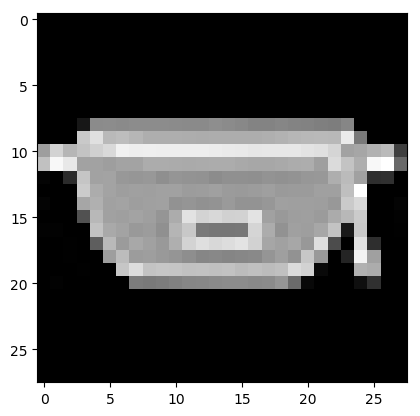

/home/titan/miniconda3/envs/deeplearn_project/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/titan/miniconda3/envs/deeplearn_project/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


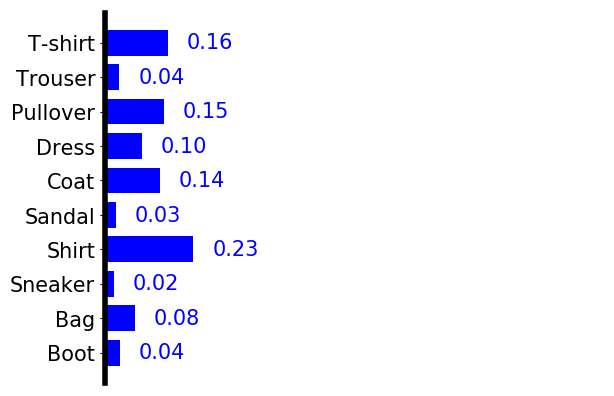

In [26]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
im=im.view(1,28,28).unsqueeze(dim=1)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
utils.show_prob_fashion_mnist(probs.cpu())

In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


from random import randint
import utils as ut 
import time

import numpy as np
import tensorflow as tf
from tensorflow.python.platform import flags
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms


#from util import get_normalized_data

from cleverhans.attacks import *
from cleverhans.model import CallableModelWrapper
from cleverhans.utils import AccuracyReport
from cleverhans.utils_pytorch import convert_pytorch_model_to_tf

In [19]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)



cuda


In [20]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
test_data=torch.load(data_path+'mnist/test_data.pt')
test_label=torch.load(data_path+'mnist/test_label.pt')

In [21]:
class two_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size,  output_size):
        super(two_layer_net , self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size  , output_size   , bias=False  )
        
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        scores  = self.layer2(y_hat)
        
        return scores

In [22]:
net_basic=two_layer_net(784,50,10)

print(net_basic)
ut.display_num_param(net_basic)

two_layer_net(
  (layer1): Linear(in_features=784, out_features=50, bias=False)
  (layer2): Linear(in_features=50, out_features=10, bias=False)
)
There are 39700 (0.04 million) parameters in this neural network


In [23]:
criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.Adam( net_basic.parameters() , lr=0.01 )

bs=20

In [24]:
net_basic = net_basic.to(device)
print(device)

cuda


In [25]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs].to(device)
        minibatch_label= test_label[i:i+bs].to(device)

        inputs = minibatch_data.view(bs,784)

        scores=net_basic( inputs ) 

        error = ut.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 ,'percent')

In [26]:
start = time.time()

for epoch in range(70):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(60000)
 
    for count in range(0,60000,bs):
        
        # forward and backward pass
    
        optimizer.zero_grad()
        
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices].to(device)
        minibatch_label= train_label[indices].to(device)

        inputs = minibatch_data.view(bs,784)

        inputs.requires_grad_()

        scores=net_basic( inputs ) 

        loss =  criterion( scores , minibatch_label) 
        
        loss.backward()

        optimizer.step()
        
        
        # compute some stats
        
        running_loss += loss.detach().item()
               
        error = ut.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
    
    
    # once the epoch is finished we divide the "running quantities"
    # by the number of batches
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed_time = time.time() - start
    
    # every 10 epoch we display the stats 
    # and compute the error rate on the test set  
    
    if epoch % 5 == 0 : 
    
        print(' ')
        
        print('epoch=',epoch, '\t time=', elapsed_time,
              '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        
        eval_on_test_set()
               

 
epoch= 0 	 time= 2.5193660259246826 	 loss= 0.2690667844738734 	 error= 7.801665874322255 percent
test error  =  5.349999535083771 percent
 
epoch= 5 	 time= 14.930984020233154 	 loss= 0.14796791654793331 	 error= 3.69999988079071 percent
test error  =  4.219999670982361 percent
 
epoch= 10 	 time= 27.570799589157104 	 loss= 0.13248734433974454 	 error= 3.0833333293596903 percent
test error  =  4.5899995803833 percent
 
epoch= 15 	 time= 40.74290418624878 	 loss= 0.11790682019833534 	 error= 2.646666677792867 percent
test error  =  4.699999654293061 percent
 
epoch= 20 	 time= 53.69309449195862 	 loss= 0.11010947166443791 	 error= 2.3983334402243295 percent
test error  =  4.10999972820282 percent
 
epoch= 25 	 time= 66.93319535255432 	 loss= 0.111818331362951 	 error= 2.1600001414616905 percent
test error  =  4.149999690055847 percent
 
epoch= 30 	 time= 79.75866222381592 	 loss= 0.09584278892549558 	 error= 2.0266667644182843 percent
test error  =  4.419999599456787 percent
 
epoch=

In [27]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data.view(60000,784), train_label))
     
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data.view(10000,784), test_label))

sess = tf.Session()
x_op1 = tf.placeholder(tf.float32, shape=(None,784,))
#x_op2 = tf.placeholder(tf.float32, shape=(None,3, 32, 32,))


# Convert pytorch model to a tf_model and wrap it in cleverhans
tf_net = convert_pytorch_model_to_tf(net_basic)
cleverhans_model = CallableModelWrapper(tf_net, output_layer='logits')


In [28]:
# Create an FGSM attack
fgsm_op = FastGradientMethod(cleverhans_model, sess=sess)
fgsm_params = {'eps': 0.3,
                 'clip_min': 0.,
                 'clip_max': 1.}
adv_x_op = fgsm_op.generate(x_op1, **fgsm_params)
adv_preds_op = tf_net(adv_x_op)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
no_runs = 10000
correct = 0

dist_mnist_list = []
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    dist_mnist_list.append( max(np.reshape(np.array(adv_example-xs), 784)))
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()
    

In [30]:
dist_mnist = np.array(dist_mnist_list)  
acc = float(correct) / no_runs

print('Adversarial accuracy with FGSM attack for MNIST: {:.3f}'.format(acc * 100))

Adversarial accuracy with FGSM attack for MNIST: 63.090


In [31]:
import matplotlib as plt

(array([3969.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6031.]),
 array([0.        , 0.03      , 0.06000001, 0.09000001, 0.12000002,
        0.15000002, 0.18000002, 0.21000002, 0.24000004, 0.27000004,
        0.30000004], dtype=float32),
 <a list of 10 Patch objects>)

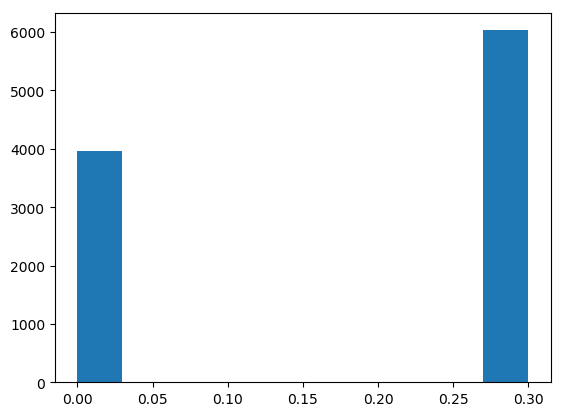

In [32]:
plt.pyplot.hist(dist_mnist)

In [33]:
mi_op = MomentumIterativeMethod(cleverhans_model, sess=sess)

mi_params = { 'eps' : 0.3, 'eps_iter' : 0.06, 'nb_iter' : 10} #'y': None, 'ord' : inf, 'decay_factor' : 1.0, 'clip_min' : None, 'clip_max' : None, 'y_target' : None}

adv_x_op = mi_op.generate(x_op1, **mi_params)
adv_preds_op = tf_net(adv_x_op)

no_runs = 10000
correct = 0
for xs, ys in test_loader:
    xs, ys = Variable(xs), Variable(ys)
    adv_example = sess.run(adv_x_op, feed_dict={x_op1: xs})
    adv_preds = sess.run(adv_preds_op, feed_dict={adv_x_op: adv_example})
    correct += (np.argmax(adv_preds, axis=1) == ys).sum()

acc = float(correct) / no_runs

print('Adversarial accuracy with MomentumIterative method attack on MNIST: {:.3f}'.format(acc * 100))



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Adversarial accuracy with MomentumIterative method attack on MNIST: 60.480
